# LM-32 - Apprendimento Automatico e Apprendimento Profondo
## Progetto di sviluppo di un progetto di machine/deep learning
## Infurna Giuseppe
## Matricola: 0322500071
## Bank Marketing Classification

In questo progetto ho utilizzato un dataset pubblico disponibile sul repository UCI Machine Learning, in particolare il dataset Bank Marketing.

Il dataset viene caricato tramite una libreria che permette di scaricare automaticamente i dati e le relative informazioni descrittive, come il significato delle variabili e i metadati generali.

Una volta ottenuti i dati, li ho separati in due parti: le feature, che rappresentano le informazioni sui clienti e sul contesto della campagna di marketing, e la variabile target, che indica se il cliente ha sottoscritto o meno il deposito.

Poiché molte feature sono categoriche, come il tipo di lavoro o lo stato civile, è stato necessario convertirle in formato numerico. Per farlo ho utilizzato una codifica one-hot, che trasforma ogni categoria in una variabile binaria, cosi chè gli algoritmi di machine learning abbianodati numerici su cui lavorare dato che non possono interpretare direttamente variabili categoriche

Per evitare ridondanze tra le feature e problemi di multicollinearità, ho eliminato una categoria di riferimento per ogni variabile categorica.

Anche la variabile target è stata trasformata in formato numerico, mappando il valore ‘yes’ a 1 e il valore ‘no’ a 0, in modo da poter applicare algoritmi di classificazione binaria.

Al termine di questo processo, il dataset risulta completamente numerico ed è quindi pronto per essere utilizzato nei modelli di machine learning.
Questo preprocessing garantisce coerenza matematica dei dati e permette ai modelli di apprendere correttamente le relazioni tra le variabili.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

import shap
from lime.lime_tabular import LimeTabularExplainer
import IPython
import IPython.display
import IPython.core.display
import seaborn as sns

Effettuiamo una trasformazione dei dati per renderli adatti sia all’analisi delle feature sia all’addestramento dei modelli.

Applico una standardizzazione delle feature, in modo che tutte le variabili abbiano media zero e deviazione standard unitaria. Questo passaggio è fondamentale perché tecniche come la PCA sono sensibili alla scala delle variabili.

In [36]:

from ucimlrepo import fetch_ucirepo

# Scarica il dataset Bank Marketing dal repository UCI
bank_marketing = fetch_ucirepo(id=222) 

# Estrae le feature (cioè le variabili di input) dal dataset come pandas dataframes
X_draft = bank_marketing.data.features 
# Estrae la variabile target (cioè la classe da predire) dal dataset come pandas dataframes
y_draft = bank_marketing.data.targets 

#print("Stampa le informazioni generali del dataset Ad esempio: uci_id, name, anno, repository_url...")
#print(bank_marketing.metadata) 

#print("Stampa la descrizione delle singole variabili per capire il significato di ogni feature")
#print(bank_marketing.variables)

n_totale = X_draft.shape[0]

#identificazione dei record non nulli
mask_not_null = X_draft.notnull().all(axis=1)

X = X_draft[mask_not_null]
y = y_draft[mask_not_null]

#stampa riassuntiva dei record
n_validi = X.shape[0]
n_scartati = n_totale - n_validi

print(f"Record totali: {n_totale}")
print(f"Record utilizzati (senza valori nulli): {n_validi}")
print(f"Record esclusi (con almeno un valore nullo): {n_scartati}")


# Trasforma automaticamente le variabili categoriche in variabili numeriche
# Ogni categoria diventa una colonna binaria (0 o 1)
# drop_first=True elimina una colonna per evitare ridondanze
X_encoded = pd.get_dummies(X, drop_first=True)

# Converte la variabile target da valori testuali a numerici
# "yes" diventa 1, "no" diventa 0
# y.iloc[:, 0] seleziona la prima (e unica) colonna del DataFrame y
y_encoded = y.iloc[:, 0].map({"yes": 1, "no": 0})

X = X_encoded
y = y_encoded




### Suddivido Training, Validation e Test con le librerie di scikit-learn 
# Suddivido  in Train (70%) e temp (30%) per dividere poi Test e Validation 
# faccio la stratificazione
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Suddivido il set temporaneo in Validation (20%) e Test (10%) buon compromesso non essendo il dataset molto grande
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.33, random_state=42, stratify=y_temp
)

#  effettuo la Standardizzazione dei Dati (operazione molto importante per PCA, LogReg, e SVM)
scaler = StandardScaler()

# Addestro lo scaler solo sui dati di TRAIN
X_train_scaled = scaler.fit_transform(X_train)
# Trasformo tutti i set (usando lo scaler addestrato)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("\nStampo le dimensioni dei Set per verificare l'effetto dello split:")
print(f"Training set: {X_train_scaled.shape}")
print(f"Validation set: {X_val_scaled.shape}")
print(f"Test set: {X_test_scaled.shape}")


Record totali: 45211
Record utilizzati (senza valori nulli): 7842
Record esclusi (con almeno un valore nullo): 37369

Stampo le dimensioni dei Set per verificare l'effetto dello split:
Training set: (5489, 38)
Validation set: (1576, 38)
Test set: (777, 38)


# __1.__ Analisi delle feature del dataset scelto mediante l’implementazione dell’algoritmo PCA per le feature scelte e visualizzazione dei risultati


Suddivido il dataset in un insieme di training e uno di test, mantenendo la stessa distribuzione delle classi grazie allo stratified split. In questo modo posso valutare le prestazioni dei modelli su dati mai visti.

in questa fase lo scopo è trovare le componenti principali e se possibile ridurre la dimensionalità
individuando eventuali ridondanze e multicollinearità




Training set: 5489
Test set: 2353
Componenti necessarie per spiegare il 95% della varianza: 32


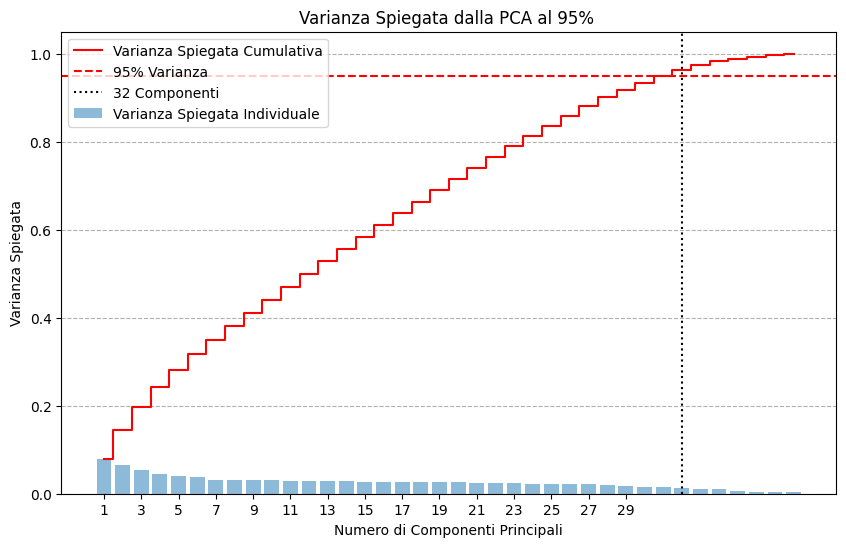

In [37]:

scaler = StandardScaler()
# Applica la standardizzazione a tutte le feature X
X_scaled = scaler.fit_transform(X)


# Suddivido Training, Validation e Test con le librerie di scikit-learn 
# Suddivido  in Train (70%) e temp (30%) per dividere poi Test e Validation 
# faccio la stratificazione
#random_state=42 rende la divisione riproducibile
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
#print('Train size:', X_train.shape[0], 'Test size:', X_test.shape[0])
print(f"Training set: {X_train.shape[0]}")
#print(f"Validation set: {X_val_scaled.shape}")
print(f"Test set: {X_test.shape[0]}")


# --- 1. Analisi delle feature e implementazione dell’algoritmo PCA ---
# Applico la PCA solo sul set di TRAIN SCALATO
# Inizialmente calcolo tutte le 38 feature principali (n_components=None)
pca = PCA(n_components=None) 
pca.fit(X_train)

# Trasformo il set di TRAIN
X_train_pca = pca.transform(X_train)

# --- ANALISI DELLA VARIANZA SPIEGATA ---
# Calcolo della varianza spiegata cumulativa
varianza_cumulativa = np.cumsum(pca.explained_variance_ratio_)

# cerco quante componenti servono per spiegare il 95% della varianza, in modo da rilevare multicollinearità o variabili superflue 
# np.argmax trova il primo indice in cui la condizione è soddisfatta
n_95 = np.argmax(varianza_cumulativa >= 0.95) + 1 # +1 perché gli indici partono da 0

print(f"Componenti necessarie per spiegare il 95% della varianza: {n_95}")

# Creo lo Scree Plot per visualizzare la Varianza Spiegata
plt.figure(figsize=(10, 6))

# Varianza Spiegata per Componente
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, 
        alpha=0.5, align='center', label='Varianza Spiegata Individuale')

# Varianza Spiegata Cumulativa
plt.step(range(1, len(pca.explained_variance_ratio_) + 1), varianza_cumulativa, 
         where='mid', label='Varianza Spiegata Cumulativa', color='red')

# Linea per il 95% (obiettivo)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Varianza')

# Linea verticale per il numero di componenti a 95%
plt.axvline(x=n_95, color='k', linestyle=':', label=f'{n_95} Componenti')

plt.xlabel('Numero di Componenti Principali')
plt.ylabel('Varianza Spiegata')
plt.title('Varianza Spiegata dalla PCA al 95% ')
plt.legend(loc='best')
plt.grid(axis='y', linestyle='--')
plt.xticks(range(1, 31, 2))
plt.show()




Applico la PCA (Principal Component Analysis) riducendo la dimensionalità a due componenti principali. Questo mi permette di proiettare i dati in uno spazio bidimensionale mantenendo la massima quantità possibile di varianza.

Visualizziamo la proiezione PCA tramite uno scatter plot, colorando i punti in base alla classe, per osservare il grado di separabilità tra le due classi.

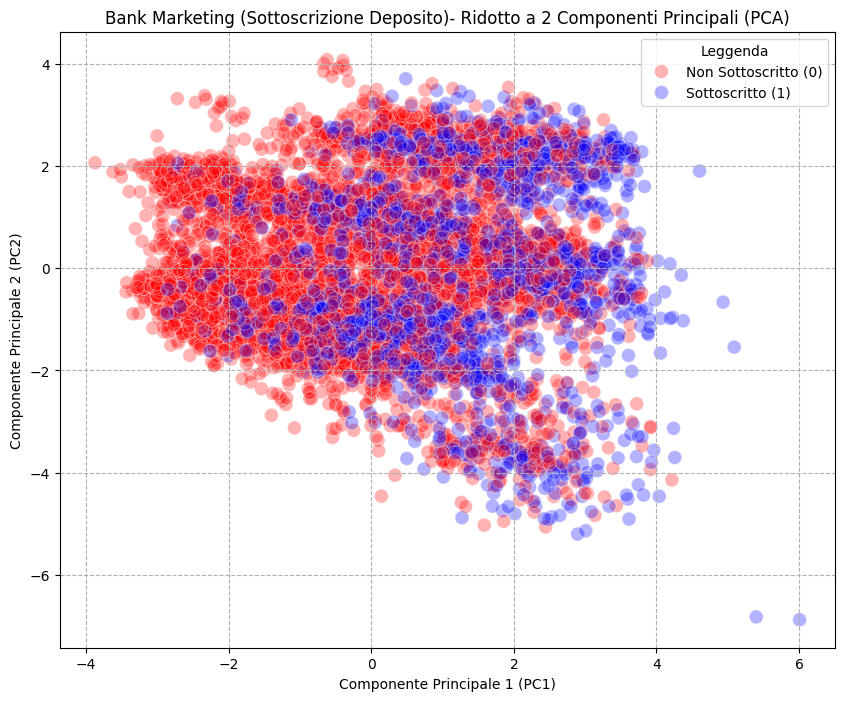

In [38]:
# PCA con 2 componenti per visualizzare la separazione delle classi
pca_2d = PCA(n_components=2)
pca_2d.fit(X_scaled)

# Trasformiamo i dati di TRAIN nel nuovo spazio 2D
X_train_2d = pca_2d.transform(X_scaled)

# Creiamo un DataFrame per la visualizzazione con Matplotlib/Seaborn
df_pca = pd.DataFrame(data=X_train_2d, columns=['PC1', 'PC2'])
df_pca['Target'] = y.values # Aggiungo il target (0: Non Sottoscritto, 1: Sottoscritto)

# Mappa per etichettare meglio le classi
target_names = {0: 'Non Sottoscritto (0)', 1: 'Sottoscritto (1)'}
df_pca['Target Label'] = df_pca['Target'].map(target_names)

# Plotting con Seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x="PC1", 
    y="PC2", 
    hue="Target Label", # Colora in base al target
    data=df_pca,
    palette=['red', 'blue'], # Colori scelti
    s=100, # Dimensione dei punti
    alpha=0.3 # Trasparenza
)
plt.title('Bank Marketing (Sottoscrizione Deposito)- Ridotto a 2 Componenti Principali (PCA)')
plt.xlabel('Componente Principale 1 (PC1)')
plt.ylabel('Componente Principale 2 (PC2)')
plt.grid(True, linestyle='--')
plt.legend(title='Leggenda')
plt.show()

# __2__. Implementazione di almeno tre degli algoritmi di classificazione 

In questa fase ho addestrato quattro modelli di classificazione: Naive Bayes, Decision Tree, Random Forest e Logistic Regression. Dopo aver diviso il dataset in training e test set in modo stratificato, ogni modello viene addestrato sul training set e valutato sul test set.


In [39]:



# Crea un dizionario che contiene i modelli di classificazione
# La chiave è il nome del modello
# Il valore è l'oggetto del modello corrispondente
models = {
    "Naive Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest (RF)": RandomForestClassifier(n_estimators=100, max_depth=5,  random_state=42),
    "Logistic Regression (LogReg)": LogisticRegression(solver='liblinear', random_state=42)
}

trained_models = {}
results = {}

# Cicla su tutti i modelli presenti nel dizionario
# name è il nome del modello
# model è l'oggetto del modello
for name, model in models.items():

    # Addestra il modello usando il training set
    model.fit(X_train, y_train)
    trained_models[name] = model # Salva il modello addestrato
    
trained_models

{'Naive Bayes': GaussianNB(),
 'Decision Tree': DecisionTreeClassifier(random_state=42),
 'Random Forest (RF)': RandomForestClassifier(max_depth=5, random_state=42),
 'Logistic Regression (LogReg)': LogisticRegression(random_state=42, solver='liblinear')}

# __3.__ Implementazione del calcolo delle metriche di valutazione precision, recall, f-measure Accuracy, Roc AUC


Per ciascun modello ho calcolato diverse metriche di valutazione, tra cui accuracy, precision, recall, F1-score e ROC AUC, in modo da avere una valutazione completa delle prestazioni.

I risultati vengono salvati in una struttura dati che consente un confronto diretto tra i modelli.

L’utilizzo di più metriche consente di valutare il comportamento dei modelli in modo più robusto rispetto alla sola accuracy, particolarmente importante in presenza di classi sbilanciate.

In [40]:

# Cicla su tutti i modelli presenti nel dizionario
# name è il nome del modello
# model è l'oggetto del modello
for name, model in trained_models.items():
    # Usa il modello addestrato per predire le classi sul test set
    y_pred = model.predict(X_test)
    # Calcola la probabilità di appartenenza alla classe positiva
    # [:, 1] seleziona la probabilità della classe "1"
    # Serve per calcolare la ROC AUC
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)

    # Salva tutte le metriche di valutazione in un dizionario
    # Ogni metrica misura un aspetto diverso delle prestazioni
    results[name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob),
        "y_pred":y_pred,
        "y_prob":y_prob

    }

# Converto i risultati in un DataFrame per una visualizzazione chiara
df_metriche = pd.DataFrame({k: {m: v for m, v in val.items() if m not in ['y_pred', 'y_prob']} 
                            for k, val in results.items()}).T
print("\n--- TABELLA RIASSUNTIVA DELLE METRICHE ---")
print(df_metriche.round(4))


--- TABELLA RIASSUNTIVA DELLE METRICHE ---
                              Accuracy  Precision  Recall      F1  ROC AUC
Naive Bayes                     0.5206     0.3145  0.9366  0.4709   0.8269
Decision Tree                   0.7926     0.5417  0.5821  0.5612   0.7184
Random Forest (RF)              0.8419     0.8254  0.3881  0.5279   0.8993
Logistic Regression (LogReg)    0.8406     0.6940  0.5373  0.6057   0.8897


# __4.__ Implementazione della visualizzazione della matrice di confusione e della ROC AUC Curve

Utilizziamo matplot per stampare le Confusion Matrix
ed il grafico ROC AUC che è una buona metrica per valutare la capacità del modello di distinguere tra le classi,
indipendentemente dalla soglia di classificazione.

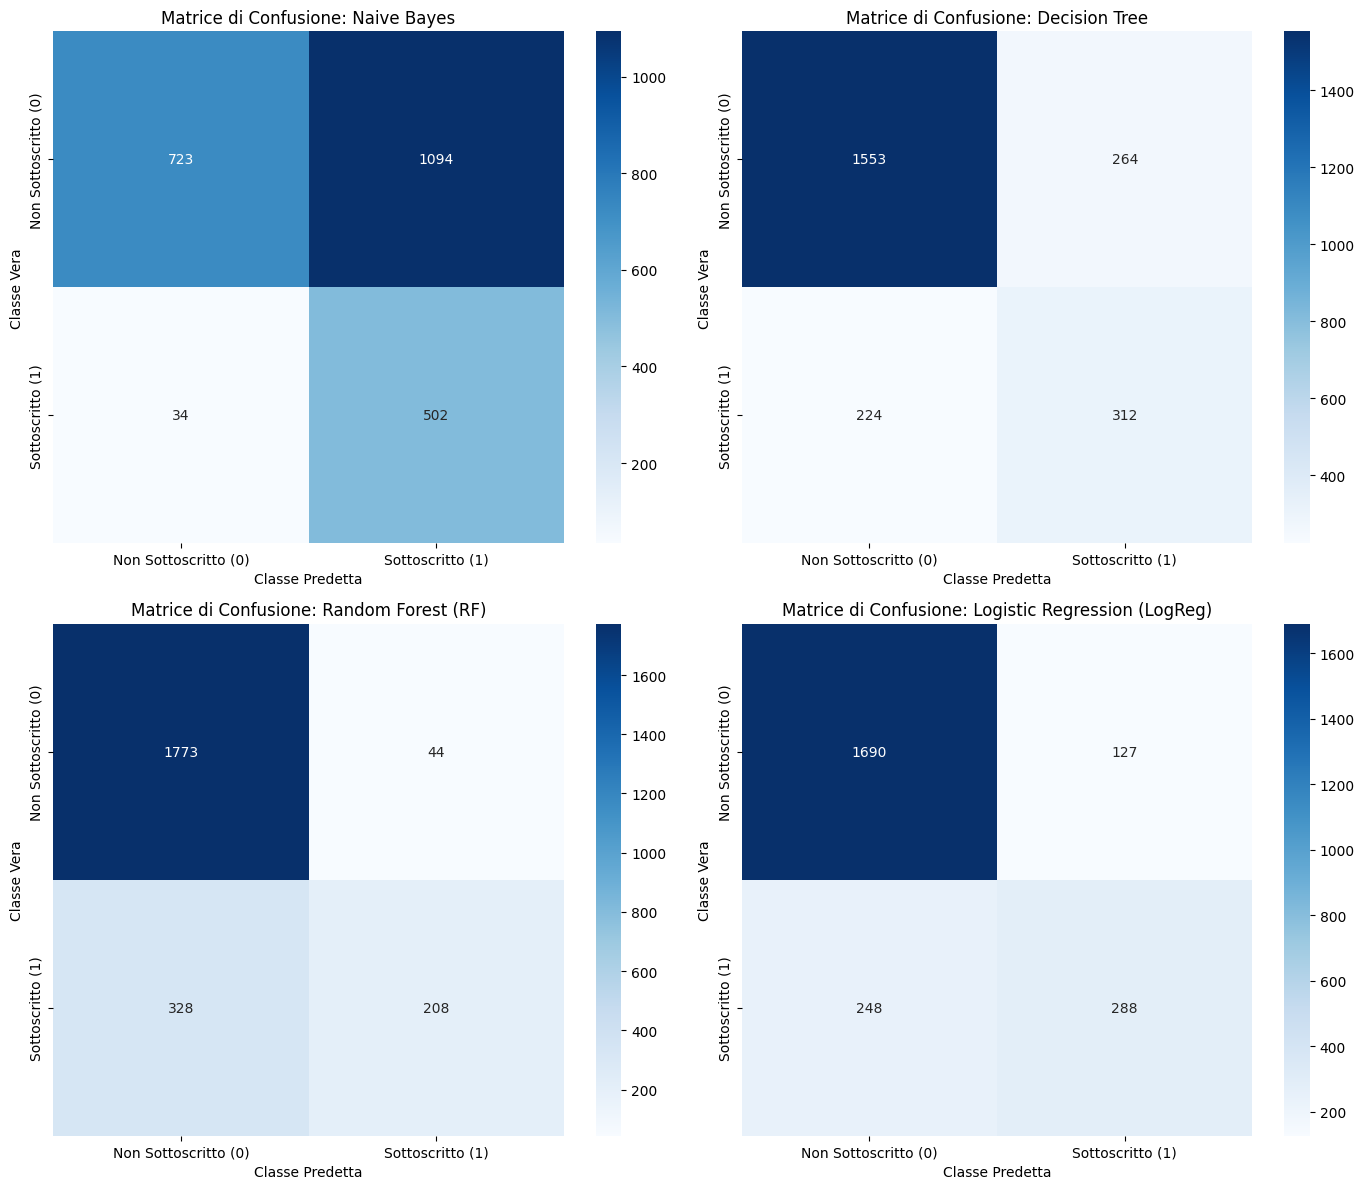

In [41]:

# 4.1. Visualizzazione delle Matrici di Confusione per tutti i 4 modelli

# Dizionario per i nomi delle etichette (più chiare per il plot)
target_labels = {0: 'Non Sottoscritto (0)', 1: 'Sottoscritto (1)'}

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten() # Rende gli assi accessibili in un array 1D

# con un ciclo stampo le matrici di tutti i modelli utilizzati
for i, (name, metrics) in enumerate(results.items()):
    
    y_pred = metrics['y_pred']
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot della matrice
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=target_labels.values(), 
                yticklabels=target_labels.values(),
                ax=axes[i])
    # ogni matrice con il la sua intestazione di modello
    axes[i].set_title(f'Matrice di Confusione: {name}')
    axes[i].set_ylabel('Classe Vera')
    axes[i].set_xlabel('Classe Predetta')

plt.tight_layout()
plt.show()


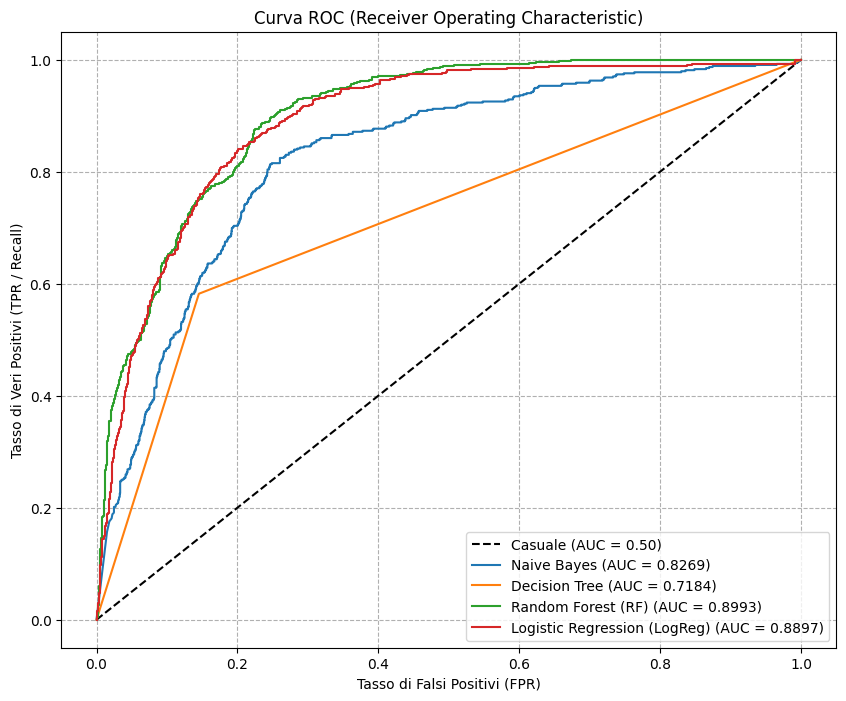

In [42]:
# --- ROC AUC Curve ---

plt.figure(figsize=(10, 8))
plt.plot([0, 1], [0, 1], 'k--', label='Casuale (AUC = 0.50)')

for name, metrics in results.items():
    y_prob = metrics['y_prob']
    if y_prob is not None:
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
        auc = metrics['ROC AUC']
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')

plt.xlabel('Tasso di Falsi Positivi (FPR)')
plt.ylabel('Tasso di Veri Positivi (TPR / Recall)')
plt.title('Curva ROC (Receiver Operating Characteristic)')
plt.legend(loc='lower right')
plt.grid(True, linestyle='--')
plt.show()



# __5.__ Implementazione di un approccio di spiegabilità scelto tra SHAP o LIME.

Implemento SHAP (SHapley Additive exPlanations) e lo effettuo su Logistic Regression che assieme a SVM
questo aiuta a capire perché il  modello prende determinate decisioni
ci dirà quanto ogni Componente Principale ha contribuito alla predizione.

--- Punto 5b: Spiegabilità con SHAP per Logistic Regression (LogReg) ---




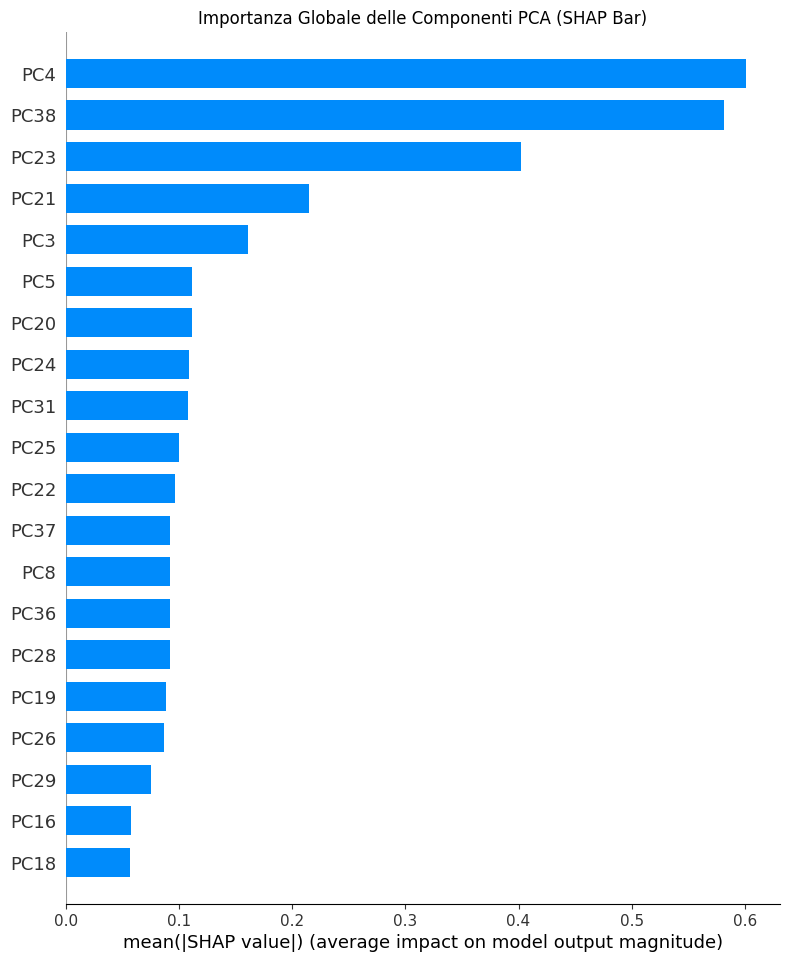

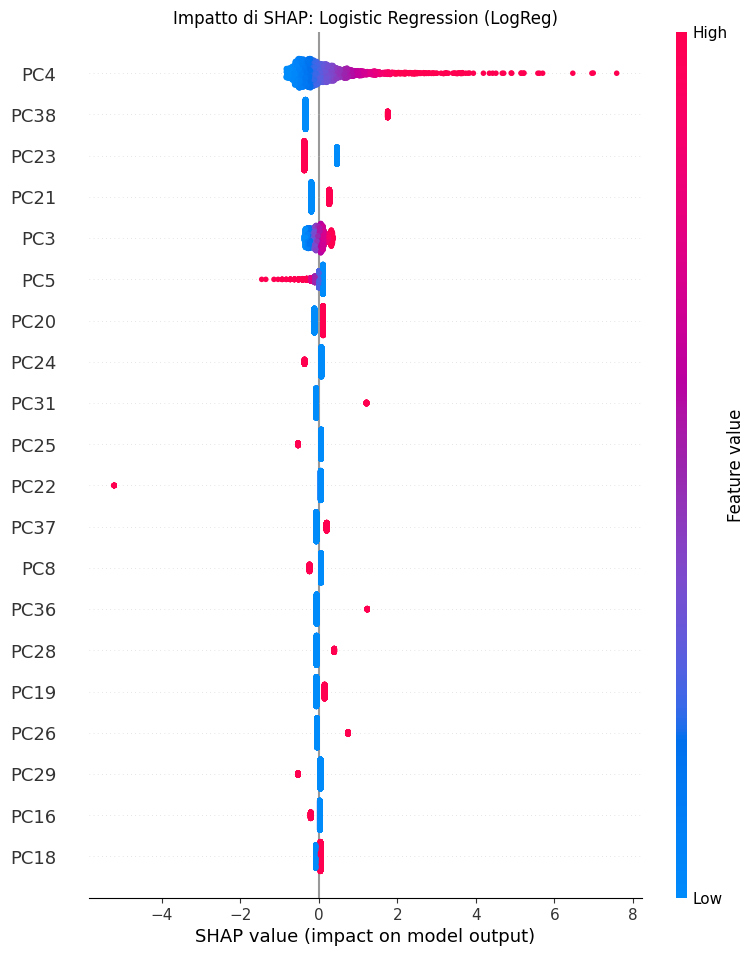

In [43]:

import shap 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# --- 5 Implementazione dell'approccio di spiegabilità SHAP

# 1. Scegliere il modello e i dati
best_model_name = 'Logistic Regression (LogReg)' 
best_model = trained_models[best_model_name]

print(f"--- Punto 5b: Spiegabilità con SHAP per {best_model_name} ---")

# 2. Inizializzare l'Explainer
# Per i modelli lineari come Logistic Regression, si usa LinearExplainer
explainer = shap.LinearExplainer(
    best_model, 
    # SHAP ha bisogno di un set di dati di background per la sua spiegazione (usiamo il Training Set)
    X_train 
)

# 3. Preparare i dati di Test per il calcolo
# Dati di test in formato array NumPy
X_test_pca_numpy = X_test 

# Per le visualizzazioni SHAP, creiamo un DataFrame con i nomi delle componenti
n_features = X_test.shape[1]
feature_names = [f'PC{i+1}' for i in range(n_features)]
X_test_pca_df = pd.DataFrame(X_test_pca_numpy, columns=feature_names) 

# 4. Calcolare i valori SHAP
# I valori SHAP qui sono in log-odds (scala del modello lineare)
shap_values = explainer.shap_values(X_test_pca_numpy) 

# --- 5. Visualizzazione Globale (Feature Importance - Bar Plot) ---
# Mostra l'importanza media assoluta di ogni componente sulla predizione.
print("\n")
shap.summary_plot(shap_values, X_test_pca_df, plot_type="bar", show=False)
plt.title(f"Importanza Globale delle Componenti PCA (SHAP Bar)")
plt.show()

# --- 6. Visualizzazione Dettagliata (Feature Impact - Beeswarm Plot) ---
# Mostra la distribuzione dell'impatto di ogni componente. 
# Il colore rappresenta il valore della feature (ad esempio, alto vs. basso)
print("\n")
shap.summary_plot(shap_values, X_test_pca_df, show=False)
plt.title(f"Impatto di SHAP: {best_model_name}")
plt.show()

Le componenti principali con maggiore impatto evidenziano come l’informazione discriminante sia distribuita su più dimensioni, coerentemente con quanto osservato nell’analisi PCA

# Conclusioni

Conclusioni (versione finale, allineata a dati + codice + grafici)

Nel presente lavoro è stato analizzato il dataset Bank Marketing con l’obiettivo di affrontare un problema di classificazione binaria relativo alla sottoscrizione di un deposito a termine. A partire dai 45211 record totali, l’analisi è stata condotta su 7842 record privi di valori nulli, mentre 37369 record sono stati esclusi a causa della presenza di almeno un valore mancante. Il dataset risultante è stato suddiviso in training set (5489 record), validation set (1576 record) e test set (2353 record).

L’analisi delle feature mediante Principal Component Analysis (PCA) ha evidenziato una forte ridondanza informativa tra le 38 variabili originali. Come mostrato dal grafico della varianza spiegata, sono necessarie 32 componenti principali per spiegare il 95% della varianza totale, indicando che l’informazione rilevante è distribuita su molte dimensioni e che una riduzione dimensionale spinta comporterebbe una perdita informativa significativa. La PCA è stata quindi utilizzata prevalentemente come strumento esplorativo e di interpretazione, e non come base esclusiva per l’addestramento dei modelli.

I modelli di classificazione sono stati addestrati utilizzando l’intero spazio delle feature preprocessate e valutati sul test set. I risultati quantitativi, riassunti nella tabella delle metriche, mostrano comportamenti differenti tra gli algoritmi considerati:

Naive Bayes presenta un’Accuracy pari a 0.5206, ma un Recall molto elevato (0.9366) a fronte di una Precision bassa (0.3145). Questo comportamento è coerente con la matrice di confusione, che evidenzia un numero molto elevato di falsi positivi e una forte tendenza del modello a classificare i record come Sottoscritto. Il modello risulta quindi sensibile ma poco selettivo.

Decision Tree raggiunge un’Accuracy di 0.7926, con valori di Precision (0.5417) e Recall (0.5821) più bilanciati rispetto a Naive Bayes, ma con una ROC-AUC pari a 0.7184, inferiore agli altri modelli. Questo suggerisce una capacità discriminante complessivamente più limitata.

Random Forest ottiene l’Accuracy più elevata (0.8419) e una Precision molto alta (0.8254), ma a fronte di un Recall contenuto (0.3881). La matrice di confusione mostra che il modello è fortemente conservativo, privilegiando la corretta classificazione dei Non Sottoscritti e riducendo i falsi positivi, ma penalizzando l’individuazione dei casi positivi. La ROC-AUC pari a 0.8993 indica comunque una buona capacità di separazione complessiva.

Logistic Regression presenta un’Accuracy di 0.8406, comparabile a quella della Random Forest, ma con un miglior equilibrio tra Precision (0.6940) e Recall (0.5373). Questo equilibrio si riflette nel F1-score più elevato (0.6057) tra i modelli analizzati, rendendo la Regressione Logistica il modello con il miglior compromesso complessivo tra sensibilità e selettività. La ROC-AUC pari a 0.8897 conferma una buona capacità discriminante.

Nel complesso, l’analisi evidenzia come il dataset presenti una struttura informativa sufficiente a supportare modelli di classificazione efficaci, ma anche un marcato trade-off tra Precision e Recall, influenzato dallo sbilanciamento delle classi. I risultati mostrano che modelli diversi ottimizzano aspetti differenti del problema: Naive Bayes massimizza il Recall, Random Forest la Precision, mentre la Regressione Logistica fornisce il miglior equilibrio complessivo.

L’integrazione delle matrici di confusione, delle metriche quantitative e dell’analisi PCA consente una valutazione completa del comportamento dei modelli, evidenziando punti di forza e limiti di ciascun approccio nel contesto specifico del problema affrontato.

Gli stessi risultati si possono estrarre dalla curva di ROC dove emerge chiaramente che:
Random Forest è il modello con le migliori prestazioni complessive, raggiungendo un AUC ≈ 0.90, indice di un’elevata capacità discriminante tra le due classi. La curva ROC si mantiene stabilmente sopra quelle degli altri modelli, soprattutto nelle regioni a basso tasso di falsi positivi (FPR), aspetto cruciale in contesti applicativi sensibili agli errori.
Logistic Regression mostra prestazioni molto competitive (AUC ≈ 0.89), risultando solo leggermente inferiore alla Random Forest. Questo risultato è particolarmente rilevante considerando la maggiore semplicità e interpretabilità del modello.
Naive Bayes ottiene un’AUC intermedia (≈ 0.83), indicando una buona capacità predittiva ma una minore flessibilità nel catturare relazioni complesse tra le variabili.
Decision Tree risulta il modello meno performante (AUC ≈ 0.72), con una curva ROC più vicina alla diagonale casuale, segnale di una capacità discriminante limitata e di una maggiore sensibilità al rumore dei dati.
Nel complesso, la curva ROC conferma che Random Forest e Logistic Regression rappresentano il miglior compromesso tra sensibilità (TPR) e specificità (1 − FPR).


L’uso dei valori SHAP applicati alla Logistic Regression consente di interpretare in modo dettagliato il contributo delle singole componenti PCA alla decisione del modello.
Il grafico a barre dell’importanza globale (mean |SHAP value|) conferma quantitativamente quanto evidenziato successivamente nel summary plot:
PC4 e PC38 dominano nettamente il ranking delle componenti più importanti.
Le prime 4–5 componenti spiegano una quota significativa dell’impatto totale sul modello, mentre le restanti contribuiscono in modo via via decrescente.
Questo risultato suggerisce che, nonostante l’uso della PCA, il modello mantiene una struttura decisionale relativamente concentrata, potenzialmente utile anche per future riduzioni dimensionali.

Nello SHAP Summary Plot (Beeswarm) la PC4 emerge come la variabile più influente: valori elevati di questa componente contribuiscono fortemente ad aumentare la probabilità della classe positiva, come evidenziato dall’ampia dispersione dei valori SHAP positivi.
PC38, PC23 e PC21 hanno anch’esse un impatto rilevante, seppur inferiore rispetto a PC4, confermando che l’informazione discriminante non è concentrata su una sola dimensione ma distribuita su più componenti.
Le componenti con valori SHAP prossimi allo zero (es. PC16, PC18) hanno un’influenza marginale sul modello, suggerendo un contributo limitato alla previsione finale.
Il gradiente cromatico (da blu a rosso) indica inoltre una relazione coerente tra valore della feature e direzione dell’impatto, rafforzando l’affidabilità delle interpretazioni.

__In sintesi:__

Random Forest è il modello con le migliori prestazioni predittive, ma presenta una minore interpretabilità.
Logistic Regression, pur leggermente meno performante, offre un eccellente compromesso tra accuratezza e spiegabilità, come dimostrato dall’analisi SHAP.
L’integrazione tra curva ROC e SHAP consente non solo di valutare quanto il modello funziona bene, ma anche perché prende determinate decisioni.

Alla luce di questi risultati, la Logistic Regression con supporto SHAP rappresenta una scelta particolarmente solida in contesti applicativi in cui la trasparenza del modello è un requisito fondamentale, mentre la Random Forest risulta preferibile quando l’obiettivo primario è massimizzare la performance predittiva.
